In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('drive/MyDrive/ML/IBM.csv',index_col='Date', parse_dates=['Date'])
#data = pd.read_csv('C:\\Users\\Астемир\\Desktop\\Эконометрика\\IBM.csv',index_col='Date', parse_dates=['Date'])
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
data.shape

(3020, 6)

In [4]:
train = data[:'2016'].iloc[:,1:2].values
test = data['2017':].iloc[:,1:2].values

In [5]:
train.shape

(2769, 1)

In [6]:
test.shape

(251, 1)

In [7]:
# Функция отрисовки
def plot_predictions(test,predicted):
    plt.plot(test, color='blue',label='Real IBM Stock Price')
    plt.plot(predicted, color='red',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

In [8]:
def mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [9]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Будем предсказывать по самой высокой цене за день (атрибут High)

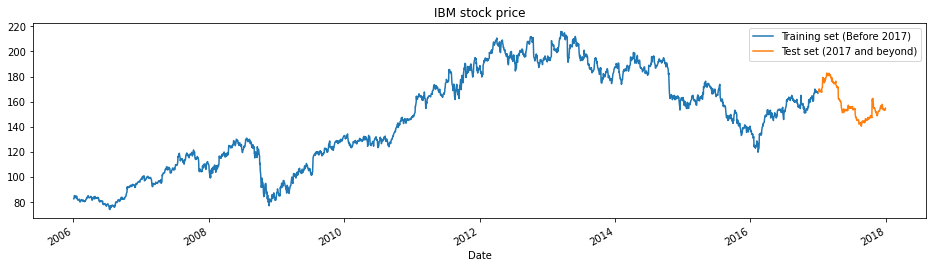

In [10]:
data["High"][:'2016'].plot(figsize=(16,4),legend=True)
data["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [11]:

# Нормирование
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(train_scaled[i-60:i,0])
    y_train.append(train_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# LSTM

In [13]:
model_LSTM = Sequential()

model_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units=50, return_sequences=True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units=50, return_sequences=True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units=50))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(Dense(units=1))


model_LSTM.compile(optimizer='adam',loss='mean_squared_error')

model_LSTM.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 8s 13ms/step - loss: 0.0706
Epoch 2/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0060
Epoch 3/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0047
Epoch 4/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0040
Epoch 5/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0043
Epoch 6/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0037
Epoch 7/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0041
Epoch 8/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0038
Epoch 9/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 10/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0040
Epoch 11/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0031
Epoch 12/50
85/85 [==============================] - 1s 12ms/step - loss: 0.0029
Epoch 13/50
85/85 [==================

In [14]:
data_total = pd.concat((data["High"][:'2016'],data["High"]['2017':]),axis=0)
inputs = data_total[len(data_total)-len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [15]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predictions_LSTM = model_LSTM.predict(X_test)
predictions_LSTM = sc.inverse_transform(predictions_LSTM)

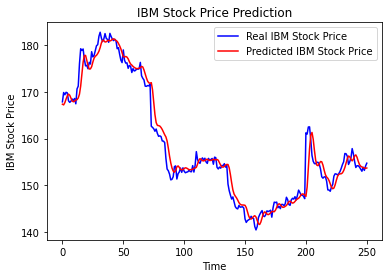

In [16]:
plot_predictions(test,predictions_LSTM)

In [17]:
mse_LSTM = mse(test,predictions_LSTM)
mse_LSTM

5.674692958883383

In [18]:
mape_LSTM = mape(test,predictions_LSTM)
mape_LSTM

0.9920947591326456

# GRU

In [19]:
model_GRU = Sequential()

model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units=50, activation='tanh'))
model_GRU.add(Dropout(0.2))

model_GRU.add(Dense(units=1))

model_GRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

model_GRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 5s 20ms/step - loss: 0.1615
Epoch 2/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0487
Epoch 3/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0162
Epoch 4/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0050
Epoch 5/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0043
Epoch 6/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0037
Epoch 7/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0037
Epoch 8/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0039
Epoch 9/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0036
Epoch 10/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0036
Epoch 11/50
19/19 [==============================] - 0s 12ms/step - loss: 0.0032
Epoch 12/50
19/19 [==============================] - 0s 13ms/step - loss: 0.0032
Epoch 13/50
19/19 [==================

In [20]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predictions_GRU = model_GRU.predict(X_test)
predictions_GRU = sc.inverse_transform(predictions_GRU)

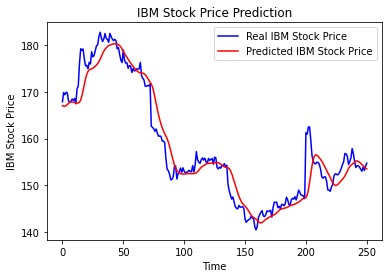

In [21]:
plot_predictions(test,predictions_GRU)

In [22]:
mse_GRU = mse(test,predictions_GRU)
mse_GRU

10.61434360381049

In [23]:
mape_GRU = mape(test,predictions_GRU)
mape_GRU

1.4151990869006803

# CNN

In [24]:
model_CNN = Sequential()
model_CNN.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
model_CNN.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_CNN.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(100, activation='relu'))
model_CNN.add(Dense(1))
model_CNN.compile(optimizer='adam', loss='mse')

model_CNN.fit(X_train, y_train, epochs=200)

Epoch 1/200
85/85 [==============================] - 1s 5ms/step - loss: 0.0356
Epoch 2/200
85/85 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 3/200
85/85 [==============================] - 0s 3ms/step - loss: 8.1260e-04
Epoch 4/200
85/85 [==============================] - 0s 3ms/step - loss: 8.6514e-04
Epoch 5/200
85/85 [==============================] - 0s 3ms/step - loss: 8.1798e-04
Epoch 6/200
85/85 [==============================] - 0s 3ms/step - loss: 5.2428e-04
Epoch 7/200
85/85 [==============================] - 0s 3ms/step - loss: 5.8774e-04
Epoch 8/200
85/85 [==============================] - 0s 3ms/step - loss: 5.9296e-04
Epoch 9/200
85/85 [==============================] - 0s 3ms/step - loss: 6.6593e-04
Epoch 10/200
85/85 [==============================] - 0s 3ms/step - loss: 9.9520e-04
Epoch 11/200
85/85 [==============================] - 0s 3ms/step - loss: 5.3842e-04
Epoch 12/200
85/85 [==============================] - 0s 3ms/step - loss: 5.5887e-

In [25]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predictions_CNN = model_CNN.predict(X_test)
predictions_CNN = sc.inverse_transform(predictions_CNN)

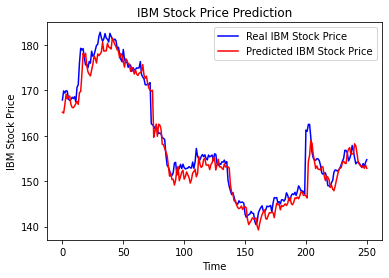

In [26]:
plot_predictions(test,predictions_CNN)

In [27]:
mse_CNN = mse(test,predictions_CNN)
mse_CNN

6.783063426860406

In [28]:
mape_CNN = mape(test,predictions_CNN)
mape_CNN

1.1384136424467055

# Результаты

In [29]:
MSE = [mse_LSTM, mse_GRU, mse_CNN]
MAPE = [mape_LSTM, mape_GRU, mape_CNN]
MSE = [round(i,4) for i in MSE]
MAPE = [round(i,4) for i in MAPE]
Model = ['LSTM','GRU','CNN']
new_models_dataframe2=pd.DataFrame({'MSE':MSE,'MAPE':MAPE},index=Model)       
new_models_dataframe2

,MSE,MAPE
LSTM,5.6747,0.9921
GRU,10.6143,1.4152
CNN,6.7831,1.1384
